In [1]:
from pandas import CategoricalDtype, read_csv
import pandas as pd

# -------------------------
# 1. 설정 정의
# -------------------------

# CSV key 목록
RE_KEYS = ('DE', 'DR', 'V')

# 기본 숫자 변환기
parse_int = lambda x: int(x) if x else 0
parse_int_comma = lambda x: int(x.replace(',', '')) if x else 0

# CSV 컬럼별 변환 함수
CONVERTERS = {
    'T': lambda x: int(x) if x else 1,
    'R': lambda x: x if x else 'A',
    'E': parse_int,
    'A': parse_int,
    'DE': parse_int,
    'DA': parse_int_comma,
    'H': parse_int_comma,
    'M': parse_int_comma,
}

# 컬럼별 dtype
DTYPES = {
    'T': CategoricalDtype((1, 2)),
    'R': CategoricalDtype(('A', 'T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'DE': 'uint8',
    'DA': 'uint16',
    'H': 'uint16',
    'M': 'uint16'
}


# -------------------------
# 2. CSV 데이터 읽기 & 병합
# -------------------------

def load_re_data():
    df_list = []
    for key in RE_KEYS:
        df = read_csv(f'R/{key}.csv', index_col=0, converters=CONVERTERS)
        df = df.astype(DTYPES, copy=False)
        df_list.append(df)
    return pd.concat(df_list, keys=RE_KEYS, names=('RE',))


df = load_re_data()
df

T  R   E  A  DE    DA     H     M
RE I                                     
DE 1    1  T   0  0   8  2947  1425  4611
   1    1  D   1  0   3  1818     0   650
   1    1  D   2  0   7  4735   487   308
   1    1  S   1  0   3  2078  2748     0
   1    1  S   1  1   3   269  5848   189
...    .. ..  .. ..  ..   ...   ...   ...
V  467  2  T   7  2   4  6453     0  9665
   467  2  D  10  0   5  6272    62  1417
   467  2  D   6  1   7  5267    78    76
   467  2  S   5  1   6  4602  8211   716
   467  2  S   2  5   7  1979  7396   329

[9110 rows x 8 columns]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   T       9110 non-null   category
 1   R       9110 non-null   category
 2   E       9110 non-null   uint8   
 3   A       9110 non-null   uint8   
 4   DE      9110 non-null   uint8   
 5   DA      9110 non-null   uint16  
 6   H       9110 non-null   uint16  
 7   M       9110 non-null   uint16  
dtypes: category(2), uint16(3), uint8(3)
memory usage: 144.9+ KB


In [3]:
from numpy import float32

values = df.iloc[:, 2:].to_numpy()
max_vals = values.max(axis=0)
normalized = (values / max_vals).astype(float32, copy=False)
normalized

array([[0.        , 0.        , 0.3478261 , 0.0984894 , 0.05393845,
        0.13442756],
       [0.01754386, 0.        , 0.13043478, 0.06075797, 0.        ,
        0.01894988],
       [0.03508772, 0.        , 0.3043478 , 0.15824477, 0.0184337 ,
        0.00897933],
       ...,
       [0.10526316, 0.01612903, 0.3043478 , 0.17602433, 0.00295242,
        0.00221568],
       [0.0877193 , 0.01612903, 0.26086956, 0.15379988, 0.31079903,
        0.02087403],
       [0.03508772, 0.08064516, 0.3043478 , 0.06613863, 0.27995002,
        0.00959156]], dtype=float32)

In [4]:
# 전체 컬럼(열) 개수 구하기
num_cols = normalized.shape[1]

# Reshape 과정:
# - normalized 배열을 10행씩 묶어서 하나의 긴 행으로 재구성
#   → reshape(-1, num_cols * 10)은 총 행 수를 10개 단위로 묶어 새로운 행으로 만든다는 의미
# - 이후 .T로 전치(transpose)하여 행/열을 뒤집음
# - 마지막으로 tuple(...)로 변환해 튜플 형태로 저장
reshaped_tuple = tuple(
    normalized.reshape(-1, num_cols * 10).T
)
len(reshaped_tuple)

60

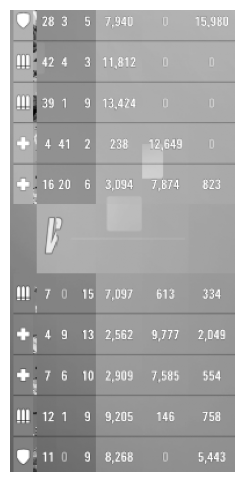

tf.Tensor(
[[   28     3     5  7940     0 15980]
 [   42     4     3 11812     0     0]
 [   39     1     9 13424     0     0]
 [    4    41     2   238 12649     0]
 [   16    20     6  3094  7874   823]
 [    7     0    15  7097   613   334]
 [    4     9    13  2562  9777  2049]
 [    7     6    10  2909  4585   554]
 [   12     1     9  9205   146   758]
 [   11     0     9  8268     0  5443]], shape=(10, 6), dtype=uint16)


2025-11-29 09:43:03.605629: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
from pathlib import Path
from tensorflow.random import shuffle
import tensorflow as tf
from tensorflow import gather, cast, reshape, transpose, convert_to_tensor
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show

image_paths = sorted(map(str, Path().rglob('*.png')))

data_count = len(image_paths)
indices = shuffle(tf.range(data_count))
X_shuffled = gather(image_paths, indices)
y_shuffled = tuple(gather(head, indices) for head in reshaped_tuple)

train_size = int(data_count * .9)
train_X = X_shuffled[:train_size]
val_X = X_shuffled[train_size:]

train_y = tuple(head[:train_size] for head in y_shuffled)
val_y = tuple(head[train_size:] for head in y_shuffled)


def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, (400, 194)) / 255
    return resized, label


def make_dataset(X, y, shuffle=False, batch_size=32):
    ds = Dataset.from_tensor_slices((X, y))
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)  # 이미지 전처리
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


train_ds = make_dataset(train_X, train_y, shuffle=True)
val_ds = make_dataset(val_X, val_y, shuffle=False)
for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(cast(tf.round((reshape(transpose(convert_to_tensor(y_batch))[0], (-1, num_cols)) * max_vals)), 'uint16'))

In [15]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, SpatialDropout2D, Flatten, Dropout, Dense
from tensorflow.keras.losses import Huber

clear_session()

input_tensor = Input(shape=x_batch.shape[1:])  # (400, 194, 1)

x = Conv2D(32, 3, padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.1)(x)

x = Conv2D(64, 3, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.1)(x)

x = Conv2D(128, 3, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.15)(x)

x = Conv2D(256, 3, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)
x = SpatialDropout2D(0.2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(256, use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

numeric_cols = df.columns.to_list()[2:]
outputs = []
for i in range(10):
    for col in numeric_cols:
        h = Dense(64, use_bias=False)(x)
        h = BatchNormalization()(h)
        h = ReLU()(h)
        h = Dropout(0.15)(h)
        outputs.append(Dense(1, name=f'{col}_{i}')(h))  # (60, 1)
model = Model(inputs=input_tensor, outputs=outputs)

loss = {}
for i in range(10):
    for col in numeric_cols:
        loss[f'{col}_{i}'] = Huber()

metrics = {}
for i in range(10):
    for col in numeric_cols:
        metrics[f'{col}_{i}'] = 'mean_absolute_error'
model.compile('adamw', loss, metrics=metrics)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 194,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 194,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 194,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 400, 194,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 200, 97,   │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 200, 97,   │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 97,   │     18,432 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 97,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 97,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 100, 48,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 100, 48,   │          0 │ max_pooling2d_1[… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 48,   │     73,728 │ spatial_dropout2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 48,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 100, 48,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 24,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_2 │ (None, 50, 24,    │          0 │ max_pooling2d_2[… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 24,    │    294,912 │ spatial_dropout2

 Total params: 21,053,404 (80.31 MB)

 Trainable params: 21,044,252 (80.28 MB)

 Non-trainable params: 9,152 (35.75 KB)

In [16]:
from tensorflow.keras.callbacks import Callback, EarlyStopping


class MetricSummaryCallback(Callback):
    def __init__(self, metric_groups=numeric_cols):
        super().__init__()
        self.metric_groups = metric_groups

    def on_train_begin(self, logs=None):
        self.total_epochs = self.params.get('epochs', None)

    def on_epoch_end(self, epoch, logs=None):
        epoch_num = epoch + 1
        total_epochs = self.total_epochs or '?'
        print(f'{epoch_num}/{total_epochs}')

        for group in self.metric_groups:
            train_logs = {
                key: value for key, value in logs.items()
                if key.startswith(group)
            }

            train_loss_values = [
                v for k, v in train_logs.items() if k.endswith('_loss')
            ]
            train_avg_loss = sum(train_loss_values) / len(train_loss_values) if train_loss_values else None
            
            train_metric_values = [
                v for k, v in train_logs.items() if k.endswith('_mean_absolute_error')
            ]
            train_avg_metric = sum(train_metric_values) / len(train_metric_values) if train_metric_values else None

            val_logs = {
                key: value for key, value in logs.items()
                if key.startswith(f'val_{group}')
            }

            val_loss_values = [
                v for k, v in val_logs.items() if k.endswith('_loss')
            ]
            val_avg_loss = sum(val_loss_values) / len(val_loss_values) if val_loss_values else None
            
            val_metric_values = [
                v for k, v in val_logs.items() if k.endswith('_mean_absolute_error')
            ]
            val_avg_metric = sum(val_metric_values) / len(val_metric_values) if val_metric_values else None

            print(
                f'- {group} '
                f'- loss: {train_avg_loss:.4f} '
                f'- mean_absolute_error: {train_avg_metric:.4f} '
                f'- val_loss: {val_avg_loss:.4f} '
                f'- val_mean_absolute_error: {val_avg_metric:.4f} '
            )


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

# 학습
history = model.fit(
    train_ds,
    epochs=256,
    verbose=0,
    callbacks=(MetricSummaryCallback(), early_stop),
    validation_data=val_ds
)

I0000 00:00:1764233101.740063    3128 service.cc:152] XLA service 0x7ccf481377f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764233101.740135    3128 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-11-27 08:45:03.150779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764233108.751767    3128 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764233153.932371    3128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-27 08:46:59.694120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 4 bytes spill stores, 4 bytes spill loads



1/256
- E - loss: 0.3299 - mean_absolute_error: 0.6579 - val_loss: 0.0381 - val_mean_absolute_error: 0.2140 
- A - loss: 0.3090 - mean_absolute_error: 0.6263 - val_loss: 0.0265 - val_mean_absolute_error: 0.1551 
- DE - loss: 0.2943 - mean_absolute_error: 0.6124 - val_loss: 0.0738 - val_mean_absolute_error: 0.3236 
- DA - loss: 0.3025 - mean_absolute_error: 0.6260 - val_loss: 0.0154 - val_mean_absolute_error: 0.1414 
- H - loss: 0.2739 - mean_absolute_error: 0.5843 - val_loss: 0.0310 - val_mean_absolute_error: 0.1857 
- M - loss: 0.2478 - mean_absolute_error: 0.5513 - val_loss: 0.0194 - val_mean_absolute_error: 0.1657 
2/256
- E - loss: 0.1548 - mean_absolute_error: 0.4015 - val_loss: 0.0299 - val_mean_absolute_error: 0.1949 
- A - loss: 0.1376 - mean_absolute_error: 0.3714 - val_loss: 0.0251 - val_mean_absolute_error: 0.1776 
- DE - loss: 0.1484 - mean_absolute_error: 0.3931 - val_loss: 0.0306 - val_mean_absolute_error: 0.1997 
- DA - loss: 0.1338 - mean_absolute_error: 0.3714 - val_lo

- E - loss: 0.0050 - mean_absolute_error: 0.0739 - val_loss: 0.0027 - val_mean_absolute_error: 0.0558 
- A - loss: 0.0027 - mean_absolute_error: 0.0516 - val_loss: 0.0017 - val_mean_absolute_error: 0.0416 
- DE - loss: 0.0063 - mean_absolute_error: 0.0843 - val_loss: 0.0040 - val_mean_absolute_error: 0.0681 
- DA - loss: 0.0040 - mean_absolute_error: 0.0648 - val_loss: 0.0024 - val_mean_absolute_error: 0.0531 
- H - loss: 0.0036 - mean_absolute_error: 0.0549 - val_loss: 0.0022 - val_mean_absolute_error: 0.0423 
- M - loss: 0.0028 - mean_absolute_error: 0.0438 - val_loss: 0.0020 - val_mean_absolute_error: 0.0356

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


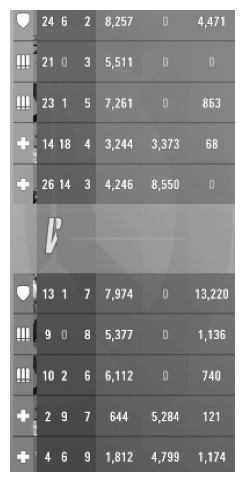

[[   24     6     2  8257     0  4471]
 [   21     0     3  5511     0     0]
 [   23     1     5  7261     0   863]
 [   14    18     4  3244  3373    68]
 [   26    14     3  4246  8550     0]
 [   13     1     7  7974     0 13220]
 [    9     0     8  5377     0  1136]
 [   10     2     6  6112     0   740]
 [    2     9     7   644  5284   121]
 [    4     6     9  1812  4799  1174]]


In [19]:
for x_batch, y_batch in val_ds.take(1):
    x_sample = x_batch[0:1]
    y_sample = (array(y_batch).T[0].reshape(-1, num_cols) * max_vals).round().astype(uint16)
    y_pred = model.predict(x_sample)
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(y_sample)

In [20]:
(array(y_pred).squeeze().reshape(-1, num_cols) * max_vals).round().astype('int32')

array([[  24,    6,    4, 9723,  649, 7403],
       [  22,    2,    5, 8128,  167,  240],
       [  22,    3,    6, 8496,  460,  460],
       [  14,   18,    4, 4089, 7773,  797],
       [  17,   16,    5, 4923, 7223,  248],
       [  11,    2,    8, 8490,  226, 9505],
       [  12,    0,    9, 8441, -141,  881],
       [  12,    1,    9, 7615,  318,  168],
       [   6,   10,    7, 3073, 8168,  377],
       [   6,    8,    7, 3055, 7231,  334]], dtype=int32)